# Computer Homework #8: Integrating the Biot-Savart Law

### Preflight will be walked through and recorded during the 3/19/2020 session.


The <b>Biot-Savart Law</b> describes how currents produce magnetic fields: 
$$
       \mathbf{B}(\vec{r}) = \frac{\mu_0}{4\pi}\int\frac{I\,d\vec{\ell}\times ({\vec{r}-\vec{r}^{\prime})}}{|r-r^\prime|^3}
$$
In this expression, $\vec{r}$ is a field point (we use a grid to sample field points), and the integral runs over all the currents, whose positions are labeled by the vector $\vec{r}^\prime$. The field point $\vec{r}$ is fixed for a particular integration. In general, this integral is difficult to evaluate analytically. This is why most introductory courses on E&M typically restrict their attention to examples like infinite straight wires, or the axis of symmetry of a loop. Fortunately, computers have no such limitations, and neither do we.

The Biot-Savart Law bears a strong mathematical resemblance to Coulomb's Law. Consequently, our numerical approach to integrating it is also similar. You may want to review [Computer Homework #2](https://github.com/Phys260WI2020/HW2/blob/master/HW_02_solutions.ipynb) to refresh your memory about electric field calculations. 

In this assignment, we'll illustrate the numerical integration of the Biot-Savart Law by applying it to the above two cases where we already know the answer. Then we'll explore some more complicated scenarios.

- First, we will look at the magnetic field due to a line wire with current flowing
- Second, we will look at the magnetic field due to a loop of current
- For the "more complicated" scenarios, you will:
    - Extend the line wire example to two wires
    - Extend the loop example to two loops
    - Solve for Helmholz coils both analytically and numerically
    
We will exploit the fact that these cases have common code to avoid re-writing code.  This includes the code to calculate the magnetic field at a point due to any number of current elements, $Id\vec{l}$. 

In [140]:
# Import the usual libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Example 1: B-field of a long, straight wire

This example will illustrate the approach that we will follow for the rest of this assignment: 
- First, we define a spatial grid of field points at which we will evaluate $B$. 
- Next, we define the current that will be the source of this field. 
- Finally, we will perform the integration and make some plots.

Field points set-up for **Example 1**: 
- Compute the field in the $y$-$z$ plane, with $-4<y<4$ and $-4<z<4$, on the plane at $x=0$.
- Let the wire be "infinite" along the $x$-axis, but define the points of the current between $-5<x<5$.

#### Define a spatial grid of points where we calculate the B-field

In [282]:
# Define the spatial grid here using np.arange and np.meshgrid. 
#   We want points sampling: x=0, -4<y,z<4. 

num_sample_points = 100 #  This determines the resolution of the spatial grid
x_gridpts, y_gridpts, z_gridpts = np.meshgrid(np.array([0]),
                                              np.linspace(-4, 4, num_sample_points),
                                              np.linspace(-4, 4, num_sample_points),
                                              indexing='ij'  # Recall, this was to keep x, y, z ordering.
                                             )

**np.meshgrid review:**  How many total points on the grid do you have?  Hint: np.size helps.  What do you expect the contents of x_gridpts to look line?  Is this the case?

In [283]:
# Review np.meshgrid here by inspecting the shape and size of np.meshgrid

**np.reshape and np.ravel explore and test**:  Create an array with elements 0, 1, 2, 3.  Use `np.reshape` to make this into a 2x2 array, print the output.  Use `np.ravel` to "flatten" the array and print the output.

In [284]:
# Explore and test np.reshape and np.ravel here

#### Define the current that is the source of the field
Next, we discretize a line of current along the x-axis from $-5<x<5$, and since this is on the x-axis, the y and z coordinates of the wire are zero.  Let $\mu_0=1$ to avoid extreme orders of magnitude that go beyond floating point precision.  Let us also set $I=1$ Amp.  Below, we create a **class** in python for a `LineWireCurrent`.

In [285]:
class LineWireCurrent() :
    '''Define a line of current. This goes from -5 to 5 along the x-axis'''
    def __init__(self, dl=0.1, I=1.0) :
        '''The __init__ function is run when you initialize a LineWireCurrent object.'''
        # The following simply creates "attributes" of the line of current
        self.dl = np.array([0.1, 0, 0])  # All of the dl's are little line segments in the x-direction
        self.xwire = np.arange(-5,5,dl)
        self.ywire = np.zeros(self.xwire.shape)
        self.zwire = np.zeros(self.xwire.shape)
        
        # Pick simple values for the constant mu_0 and the current.
        self.mu0 = 1
        self.I = I  

In [286]:
lwc = LineWireCurrent(I=2.0)
print('Current in this wire is: ',lwc.I)

Current in this wire is:  2.0


#### We'll next want a function to calculate the magnetic field at a point (one of the grid points) for a given current, like LineWireCurrent
Let's first remind ourselves of how np.cross works again....

Let's examine what np.cross does between a 1x3 vector and a 2x3 vector:

In [287]:
print('Our 1x3 vector:')
array_1x3 = np.array([1,0,0])
print(array_1x3)
print('Our 2x3 vector:')
array_2x3 = np.array([[1,0,0],[0,1,0]])
print(array_2x3)
print('with shape:')
print(array_2x3.shape)
print('The cross product is:')
np.cross(array_1x3, array_2x3)

Our 1x3 vector:
[1 0 0]
Our 2x3 vector:
[[1 0 0]
 [0 1 0]]
with shape:
(2, 3)
The cross product is:


array([[0, 0, 0],
       [0, 0, 1]])

Let's create a 3x2 array instead.  What do we have to do to get the cross product working for this?

In [288]:
#  Test out 3x2 here
array_3x2 = array_2x3.T
print(array_3x2)
print('has shape:')
print(array_3x2.shape)

# FILL OUT SOLUTION TO GETTING A WORKING CROSS PRODUCT HERE - look up the documentation

[[1 0]
 [0 1]
 [0 0]]
has shape:
(3, 2)


Let's now test out another numpy function np.divide.  We know we can do element-wise addition, subtraction, division, and multiplications, e.g. `np.array([1,0,0]) / 1`.  But, what if we wanted to divide every row (or every column) by a different number?  The method, `np.divide` allows us to do just that.  Create a 3x5 array of ones, and use `np.divide` to output a 3x5 array of 3 1's, 3 1/2's, 3 1/3's, etc.

In [289]:
# Test out np.divide here
original = np.ones((3,5))
np.divide(original, np.arange(5)+1)

array([[1.        , 0.5       , 0.33333333, 0.25      , 0.2       ],
       [1.        , 0.5       , 0.33333333, 0.25      , 0.2       ],
       [1.        , 0.5       , 0.33333333, 0.25      , 0.2       ]])

In [290]:
def calc_bfield_at_point(grid_point, current_object, print_array_shapes=False) :
    '''This function expects a grid point x, y, z and a current object with attributes matching LineWireCurrent'''
        
    delta_r = np.array([grid_point[0] - current_object.xwire,
                        grid_point[1] - current_object.ywire,
                        grid_point[2] - current_object.zwire
                       ])  # This is 3 x number_dl_segments
    
    # Rename for shorthand
    mu0 = current_object.mu0
    Idl = current_object.I * current_object.dl
    
    # Key pieces of the Biot-Savart Law
    Idlxdelta_r = np.cross(Idl, delta_r, axisb=0, axisc=0)  # This has shape 3 x number_dl_segments
    cubed_normalization = np.linalg.norm(delta_r, axis=0)**3 # This has shape (number_dl_segments)
    biot_savart_integrand = np.divide(Idlxdelta_r, cubed_normalization)
    if print_array_shapes :
        print('shape of cross product', Idlxdelta_r.shape)
        print('shape of cubed_normalization', cubed_normalization.shape)
        print('shape of divide',np.divide(Idlxdelta_r, cubed_normalization).shape)
        print('Shape of the delta_r array is: ', delta_r.shape) 
    
    #  Note, "integrating", is again, summing all of the contributions from each dl
    return mu0/(4*np.pi) * np.sum(biot_savart_integrand, axis=1)

Here, we **test** the function:

In [291]:
# Let's test the function with an example point and the LineWireCurrent.  
#    For example, we KNOW the B-field decreases with distance, and we know the direction it should point 
#      if we are at a point on the y or on the z axis.
calc_bfield_at_point(np.array([0, 0.4, 0]), LineWireCurrent(I=1.0), print_array_shapes=True)

shape of cross product (3, 100)
shape of cubed_normalization (100,)
shape of divide (3, 100)
Shape of the delta_r array is:  (3, 100)


array([0.        , 0.        , 0.39661995])

####  Calculate the magnetic field at each gridpoint due to the entire current (i.e. integrate the contribution from all dl's)
Below, we construct a function that calculates the magnetic field at all grid points in space due to a wire configuration.

To do this efficiently, you'll notice we would want to execute `calc_bfield_at_point` for every index in `x_gridpts`, `y_gridpts`, and `z_gridpts` (each index allowing us to access the x, y, and z coordinate of a point).  Luckily, numpy has a method to do this called `np.apply_along_axis`.  Let us test the method with a simple function.

In [292]:
def find_euclidean_distance(arr, random_argument="blah") :
    print(random_argument)
    return np.sqrt(arr[0]**2+arr[1]**2+arr[2]**2)

test_array = np.array([[1,2,3], [0,0,0]])
print(test_array.shape)
np.apply_along_axis(find_euclidean_distance, 1, test_array, random_argument='blue')

#  Exercise:  What do you need to do if you are given the transpose of test_array, or test_array.T ? 

(2, 3)
blue
blue


array([3.74165739, 0.        ])

**Now we are ready** to calculate the B-field at all points in our meshgrid.  We have to: 
- First stack the x_gridpts, y_gridpts, and z_gridpts such that we can use `calc_bfield_at_point` for each point.  
- Second, collect the fields we care about.

In [293]:
# Stack the coordinates
stacked_gridpts = np.array([x_gridpts, y_gridpts, z_gridpts])

# Examine what we've done
print('Stacked grid shape', stacked_gridpts.shape)
print('Original y_gridpts shape:',y_gridpts.shape)

# Now, calculate the b_field in ONE LINE!
b_field = np.apply_along_axis(calc_bfield_at_point, 0, full_grid, LineWireCurrent(I=1.0))

# The magnitude of the b_field at each point is also useful
magnitude_b_field = np.linalg.norm(b_field, axis=0)

# Let's keep track of what we're doing in terms of the shape...
print('shape of the b_field array we calculated:', b_field.shape)
print('shape of the b magnitude array: ', magnitude_b_field.shape)
print('b-field magnitude shape',magnitude_b_field.shape)

# Get things back into the shape of the desired meshgrid outputs:
B_y = b_field[1][0]
B_z = b_field[2][0]

Full grid shape (3, 1, 100, 100)
Original y_gridpts shape: (1, 100, 100)
shape of the b_field array we calculated: (3, 1, 100, 100)
shape of the b magnitude array:  (1, 100, 100)
b-field magnitude shape (1, 100, 100)


Now, we **plot** the field in the yz-plane.  You may remember the imshow method from matplotlib.  It expects an NxN array.

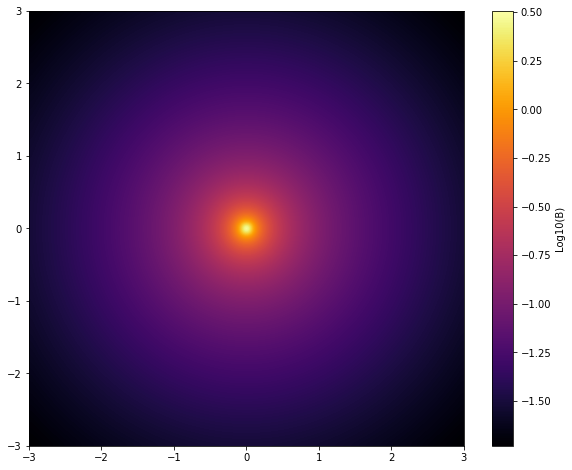

In [314]:
fig, ax = plt.subplots(1, figsize=(10,8))

nxn_portion_to_plot = magnitude_b_field[0]
img = ax.imshow(np.log10(nxn_portion_to_plot), origin='lower', interpolation='bicubic', cmap=plt.cm.inferno, 
                extent=[-3,3,-3,3])  # coordinate order is left, right, bottom, top     
cbar = fig.colorbar(img, label='Log10(B)')

Alternatively, we can also use the streamplot method.  Note, the conventions on streamplot assume the outputs of np.meshgrid with `indexing='xy'`, so we have to switch the z and y order:

Text(0,0.5,'y')

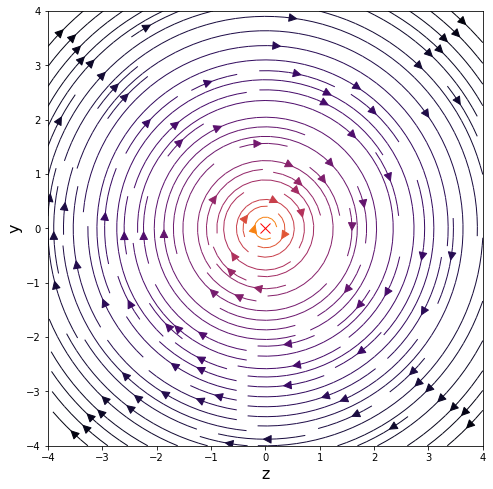

In [319]:
fig, ax1 = plt.subplots(1, figsize=(8,8))
color = 2 * np.log(magnitude_b_field[0])    # colors the arrows based on field strength

ax1.streamplot(z_gridpts[0], y_gridpts[0], B_z, B_y, color=color, linewidth=1, 
               cmap=plt.cm.inferno, density=1.5, arrowstyle='simple', arrowsize=1.5)

ax1.plot(0,0,'x', markersize=10, color='r')   # indicate the location of the wire

ax1.set_aspect('equal')
ax1.set_xlim([-4,4])
ax1.set_ylim([-4,4])
ax1.set_xlabel('z', fontsize=16)
ax1.set_ylabel('y', fontsize=16)

We can also visualize the field strength in one dimension by plotting B as a function of the radial distance from the wire. We also compare the the analytical result from Ampere's Law.  
**Exercise:**  Use `calc_bfield_at_point` to calculate the field as a function of distance along the y-axis, say from $0<y<4$.  Compare with what you know from Ampere's law.  You may try using `np.apply_along_axis` to reduce the number of code lines.

(3, 40)


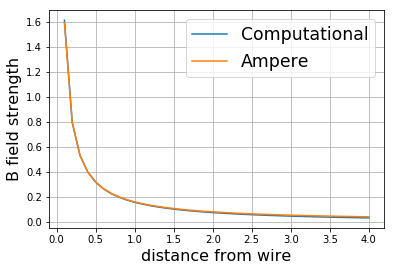

In [346]:
ypoints = np.linspace(0.1,4,40)
xpoints = np.zeros(ypoints.shape)
zpoints = np.zeros(ypoints.shape)

# Stack the points
test_points = np.array([xpoints, 
                        ypoints, 
                        zpoints])

# Calculate the field
b_field_along_y_axis = np.apply_along_axis(calc_bfield_at_point, 0, test_points, LineWireCurrent(I=1.0))
print(b_field_along_y_axis.shape)
# Calculate the magnitude
magnitude_b_along_y_axis = np.linalg.norm(b_field_along_y_axis, axis=0)

# Plot
B_ampere = 1/(2*np.pi*ypoints)
plt.plot(ypoints, magnitude_b_along_y_axis, label='Computational')
plt.plot(ypoints, B_ampere, label='Ampere')
plt.legend(fontsize='xx-large')
plt.xlabel('distance from wire', fontsize=16)
plt.ylabel('B field strength', fontsize=16)
plt.grid()

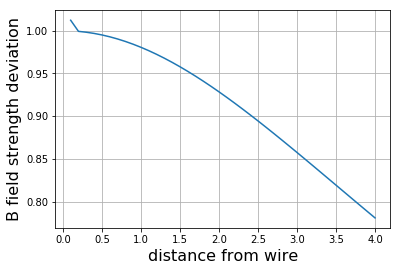

In [345]:
plt.plot(ypoints, magnitude_b_along_y_axis/B_ampere)

plt.xlabel('distance from wire', fontsize=16)
plt.ylabel('B field strength deviation', fontsize=16)
plt.grid()

## Example 2: B-field of a current loop


The next step up in complexity is the field of a current loop. It's possible to obtain an analytic solution along the axis of symmetry, but for a computer it's no additional trouble to get the field everywhere else. 

Our loop will be centered at the origin, and will be located in the $x$-$z$ plane. It will have a radius $R=1$, and carry a current of 1 A.

As before, we'll compute the field on a grid of points in the $y$-$z$ plane at $x=0$. So the loop is perpendicular to your screen... imagine half of the loop sticking out of the plane of your screen.

This integration is a little more complex than the straight wire because the direction of the current is not constant. We handle this by breaking the loop up into a finite number of segments, each with its own location and direction.



In [7]:
# define a loop of current. This is centered at the origin, has radius 1, and is in the x-z plane
R=1
nstep = 10      # number of segments to divide the loop into (code gets very slow if this is too big)
phi = np.linspace(0, 2*np.pi, nstep)
xloop = R*np.cos(phi)
yloop = np.zeros(nstep)
zloop = R*np.sin(phi)

ds = 2*np.pi*R/nstep   # element of arc length

In [8]:
# Define our spatial grid
coord_min, coord_max = -4, 4
Ngrid = 100
extent = np.linspace(coord_min, coord_max, Ngrid)
y, z = np.meshgrid(extent, extent)
field_shape = y.shape
yfield = np.ravel(y)
zfield = np.ravel(z)
Npoints = np.size(yfield)

B_x = np.zeros(Npoints)
B_y = np.zeros(Npoints)
B_z = np.zeros(Npoints)

index = np.arange(Npoints)

for i in index:   # loop over field points in our meshgrid and calculate B at each point
    if i%1000==0: print('Field point: ',i)   # to monitor progress
    dB_x = 0
    dB_y = 0
    dB_z = 0
    for j in np.arange(nstep):    # loop over segments in our loop
        x_sep = 0 - xloop[j]      # we are evaluating B in the y-z plane where x=0
        y_sep = yfield[i] - yloop[j]
        z_sep = zfield[i] - zloop[j]
        r_sep = np.sqrt(x_sep**2 + y_sep**2 + z_sep**2)
        r_hat = np.array([x_sep, y_sep, z_sep])/r_sep
        dl = ds*np.array([np.sin(phi[j]),0,-np.cos(phi[j])])    # vector describing this segment of the loop
        dl_cross_rhat = np.cross(dl, r_hat)
        dB_x += mu_0/(4*np.pi)*I*dl_cross_rhat[0]/r_sep**2
        dB_y += mu_0/(4*np.pi)*I*dl_cross_rhat[1]/r_sep**2
        dB_z += mu_0/(4*np.pi)*I*dl_cross_rhat[2]/r_sep**2
    B_x[i] = np.sum(dB_x)     # do the Biot-Savart integral by summing all the dB's.
    B_y[i] = np.sum(dB_y)
    B_z[i] = np.sum(dB_z)

# Now that we've exited the loop, unflatten the B-field arrays so that they have the same shape as our meshgrid
B_x = B_x.reshape(field_shape)
B_y = B_y.reshape(field_shape)
B_z = B_z.reshape(field_shape)
magB = np.sqrt(B_x**2 + B_y**2 + B_z**2)

Field point:  0
Field point:  1000
Field point:  2000
Field point:  3000
Field point:  4000
Field point:  5000
Field point:  6000
Field point:  7000
Field point:  8000
Field point:  9000


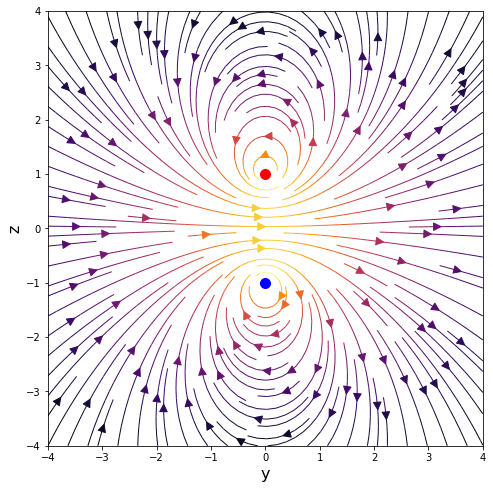

In [9]:
fig, ax1 = plt.subplots(1, figsize=(8,8))
color = 2 * np.log(magB)    # colors the arrows based on field strength
ax1.streamplot(y, z, B_y, B_z, color=color, linewidth=1, cmap=plt.cm.inferno,
              density=1.5, arrowstyle='simple', arrowsize=1.5)
ax1.plot(0,1,'o', markersize=10, color='r')   # indicate where the loop sticks in and out
ax1.plot(0,-1,'o', markersize=10, color='b')   # indicate where the loop sticks in and out
ax1.set_aspect('equal')
ax1.set_xlim([coord_min,coord_max])
ax1.set_ylim([coord_min,coord_max])
ax1.set_xlabel('y', fontsize=16)
lab = ax1.set_ylabel('z', fontsize=16)

In [10]:
# This is the exact solution along the axis of symmetry
def B_loop(z, I=1, R=1):
    return mu_0*I/2*R**2/(R**2 + z**2)**(3/2)

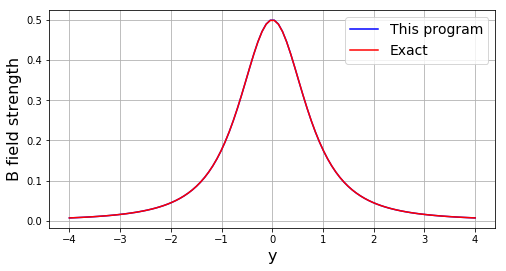

In [11]:
# Make a plot of the field strength along the y-axis at z=0
# Compare to the exact result
fix, ax = plt.subplots(1, figsize=(8,4))
mid = int(Ngrid/2)
yaxis = y[mid,:]
Baxis = B_y[mid,:]      # along the y-axis, B points in the y-direction, so use this component.
ax.plot(yaxis, Baxis, color='b', label='This program')
ax.plot(yaxis, B_loop(yaxis), color='r', label='Exact')
ax.set_xlabel('y', fontsize=16)
ax.set_ylabel('B field strength', fontsize=16)
ax.legend(fontsize=14)
ax.grid()

You can also try plotting the other components to verify that they are small.

***
## Your assignment

## Part 1 (10 points): B-field of two parallel wires

Modify the code in <b>Example 1</b> to calculate the B-field for two parallel wires. The wires should run parallel to the $x$-axis at $z=0$ and $y=\pm 1$.

a. Make a 2D plot of the field when the currents are in the same direction.

b. Make a 2D plot of the field when the currents are in opposite directions.


In [ ]:
# Your code goes here.

## Part 2 (10 points): B-field of two parallel loops

Modify the code in <b>Example 2</b> to calculate the $B$-field for two parallel loops carrying current in the same direction. The loops should be in the $x$-$z$ plane at $y=\pm 1$.

a. Make a 2D plot of the field.

b. Plot the field strength along the axis of symmetry.

In [ ]:
# Your code goes here.

## Part 3 (10 points): Helmholtz Coils (analytic version)

<b> Helmholtz coils</b> are a way of arranging two parallel loops to produce a relatively uniform magnetic field. In the lab, you use a set of Helmholtz coils that look like this:

<img src="http://www-personal.umich.edu/~gerdes/img/Set-up_5H30.20_bmp.jpg">

Using the principle of superposition, write down an expression for $B(z)$ for two parallel circular loops with radius $R$, separated by a distance $a$. Find the value of $a$ that minimizes the non-uniformity of $B(z)$ near the midpoint between the two coils. This means that you are looking for the value of $a$ that makes 
$$
        \left.\frac{d^2B}{dz^2}\right|_{z=0} = 0.
$$
(Because $B(z)$ is a symmetric function of $z$, this means that the first nonzero derivative of $B$ is $d^4B/dz^4$.)

Show your work in any of several ways:
* In LaTeX in a markdown cell in this notebook
* Using a symbolic manipulation package like Mathematica or Matlab (turn in your work as part of this submission)
* Learn about the <a href="https://docs.sympy.org/latest/index.html">sympy</a> package and show your calculation here.
* Turn in a written calculation in class by the due date for this assignment.

## Part 4 (10 points): Helmholtz Coils (numerical version)

* Modify your code from Part 2 to place the coils at the spacing you calculated in Part 3.
* Make a plot of $B(z)$ along the axis of symmetry. To better highlight the region of interest, make the limits of your plot be $-2<y<2$. This will illustrate the uniformity of the field along the axis. Approximately what is the ratio of $B(z)$ at the center of one coil to its value at the midpoint between the coils? 
* Make a plot of $B(z)$ as a function of radial distance from the center in the midplane between the two coils. This will illustrate the uniformity of the field in the transverse direction. It's extremely difficult to do this calculation analytically. Approximately what is the ratio of $B(z)$ at $r=R$ to its value at $r=0$?

In [ ]:
# Your code and discussion goes here.